# Task 2: Time Series Forecasting — Tesla Stock Prices

This notebook builds and compares two time series forecasting models for **Tesla's stock prices**:

1. **ARIMA (AutoRegressive Integrated Moving Average)** — a classical statistical model.
2. **LSTM (Long Short-Term Memory)** — a deep learning recurrent neural network.

We will:
- Load processed historical data from Task 1
- Split into train/test chronologically
- Fit, tune, and forecast using ARIMA & LSTM
- Evaluate using MAE, RMSE, and MAPE
- Compare model performance

---


In [1]:
import sys
from pathlib import Path

# Detect project root from current notebook's folder
project_root = Path().resolve().parent
sys.path.append(str(project_root))

from src.config import PROCESSED_DIR


In [2]:
# 1. Imports & Setup

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Add src/ to path
sys.path.append(str(Path("src").resolve()))

from src.config import PROCESSED_DIR

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


In [3]:

# 2. Load Processed Data
tesla_path = PROCESSED_DIR / "TSLA_processed.csv"
df = pd.read_csv(tesla_path, parse_dates=[0], index_col=0)
df.head()



,Open,High,Low,Close,Adj Close,Volume,adj_close,daily_return,log_return,vol_21d,ret_mean_21d,sma_21,sma_63
Price,,,,,,,,,,,,,
2020-01-02,28.299999237060547,28.713333129882812,28.11400032043457,28.68400001525879,28.684000,142981500,28.684000,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,29.366666793823242,30.266666412353516,29.128000259399414,29.534000396728516,29.534000,266677500,29.534000,0.029633,0.029203,NaN,NaN,NaN,NaN
2020-01-06,29.364667892456055,30.104000091552734,29.333332061767578,30.1026668548584,30.102667,151995000,30.102667,0.019255,0.019072,NaN,NaN,NaN,NaN
2020-01-07,30.760000228881836,31.441999435424805,30.224000930786133,31.270666122436523,31.270666,268231500,31.270666,0.038801,0.038067,NaN,NaN,NaN,NaN
2020-01-08,31.579999923706055,33.232666015625,31.215333938598633,32.80933380126953,32.809334,467164500,32.809334,0.049205,0.048033,NaN,NaN,NaN,NaN


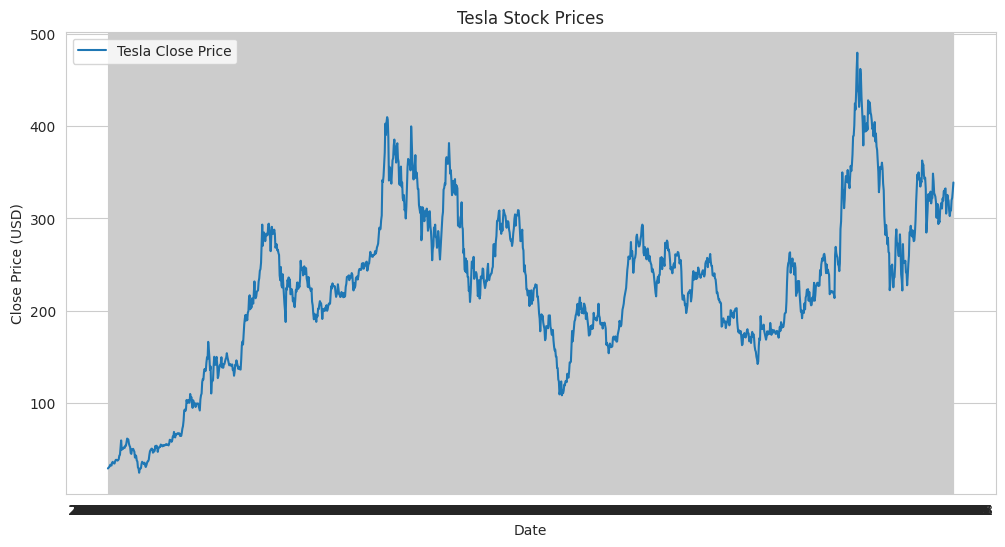

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from src.config import PROCESSED_DIR

tesla_path = PROCESSED_DIR / "TSLA_processed.csv"

# Load CSV with date index
df = pd.read_csv(tesla_path, index_col=0, parse_dates=True)

# Ensure Close column is numeric
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")

# Drop rows where Close is NaN (if any)
df = df.dropna(subset=["Close"])

# Plot close price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Tesla Close Price")
plt.title("Tesla Stock Prices")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()


In [5]:
# ======================
# 3. Train/Test Split (Chronological)
# ======================
train = df.loc[:'2023-12-31']
test = df.loc['2024-01-01':]

print(f"Train samples: {len(train)}, Test samples: {len(test)}")
train.tail(), test.head()


Train samples: 1006, Test samples: 403


(                          Open                High                 Low  \
 Price                                                                    
 2023-12-22    256.760009765625   258.2200012207031   251.3699951171875   
 2023-12-26  254.49000549316406   257.9700012207031  252.91000366210938   
 2023-12-27   258.3500061035156   263.3399963378906   257.5199890136719   
 2023-12-28   263.6600036621094   265.1300048828125   252.7100067138672   
 2023-12-29  255.10000610351562  255.19000244140625  247.42999267578125   
 
                  Close   Adj Close     Volume   adj_close  daily_return  \
 Price                                                                     
 2023-12-22  252.539993  252.539993   93370100  252.539993     -0.007701   
 2023-12-26  256.609985  256.609985   86892400  256.609985      0.016116   
 2023-12-27  261.440002  261.440002  106494400  261.440002      0.018822   
 2023-12-28  253.179993  253.179993  113619900  253.179993     -0.031594   
 2023-12-29  248.

## ARIMA Model
We start with the ARIMA model. We will:
- Use `pmdarima.auto_arima` to select (p, d, q) parameters automatically
- Fit on training data
- Forecast over the test period


In [6]:

# 4. ARIMA Model

import pmdarima as pm

arima_model = pm.auto_arima(
    train["Close"],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7175.036, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7168.729, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7169.771, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7169.796, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7167.387, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7171.049, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.442 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3582.694
Date:                Thu, 14 Aug 2025   AIC                           7167.387
Time:                        13:18:03   BIC                           7172.300
Sample:                             0   HQIC                          7169.254
                               - 1006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        73.1040      1.938     37.719      0.000      69.305      76.903
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):               571.63
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.15
Prob(H) (two-sided):                  0.15   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/ablex/Development/AI/kifiya_week11/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


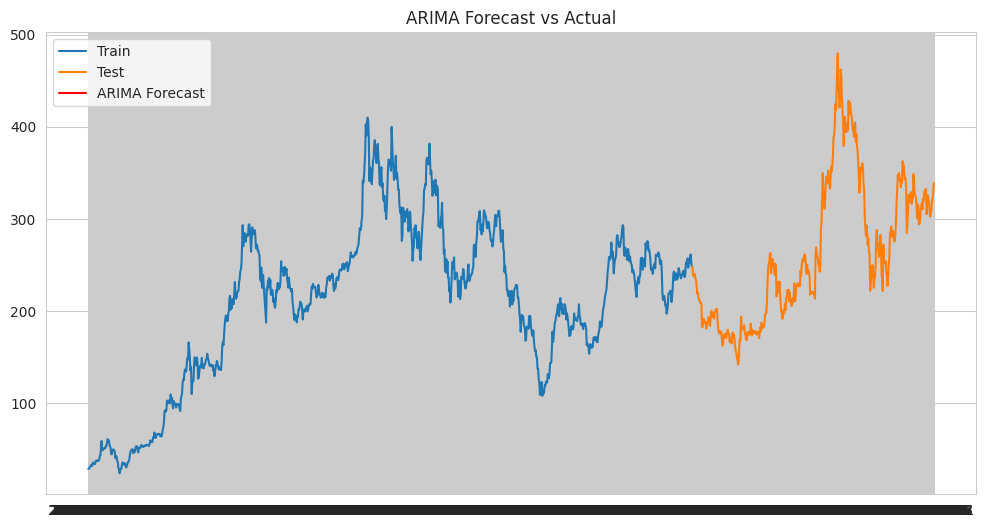

In [7]:
# Forecast
n_periods = len(test)
arima_forecast = arima_model.predict(n_periods=n_periods)
arima_forecast = pd.Series(arima_forecast, index=test.index)

# Plot ARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Close"], label="Train")
plt.plot(test.index, test["Close"], label="Test")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="red")
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()


In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert to NumPy arrays
y_true = test["Close"].to_numpy(dtype=np.float64)
y_pred = np.array(arima_forecast, dtype=np.float64)

# Match lengths
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

# Remove all NaNs
mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
y_true_clean = y_true[mask]
y_pred_clean = y_pred[mask]

if len(y_true_clean) == 0:
    print("Error: No valid data points to evaluate. Forecast contains only NaNs or test data is empty.")
else:
    arima_mae = mean_absolute_error(y_true_clean, y_pred_clean)
    arima_rmse = mean_squared_error(y_true_clean, y_pred_clean, squared=False)
    arima_mape = np.mean(np.abs((y_true_clean - y_pred_clean) / y_true_clean)) * 100

    print(f"ARIMA MAE: {arima_mae:.2f}")
    print(f"ARIMA RMSE: {arima_rmse:.2f}")
    print(f"ARIMA MAPE: {arima_mape:.2f}%")


Error: No valid data points to evaluate. Forecast contains only NaNs or test data is empty.


## LSTM Model
We now implement an LSTM model:
- Data will be scaled to [0, 1] range
- Create sequences of 60 days to predict the next day
- Train a simple LSTM with 2 layers


In [9]:
# ======================
# 5. LSTM Model
# ======================
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[["Close"]])
scaled_test = scaler.transform(test[["Close"]])

# Helper to create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X_train, y_train = create_sequences(scaled_train, SEQ_LEN)
X_test, y_test = create_sequences(np.vstack([scaled_train[-SEQ_LEN:], scaled_test]), SEQ_LEN)

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


2025-08-14 13:18:57.115860: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-14 13:18:57.313251: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-14 13:18:57.533838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755166737.696772   15960 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755166737.743339   15960 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755166738.073281   15960 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [10]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mean_squared_error")

# Train
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20


2025-08-14 13:19:12.449006: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0433
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0074
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0061
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0062
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0056
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0057
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0047
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0052
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0049
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0047
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0049
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0043
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0040
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0043
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0041
Epoch 16/20
30/

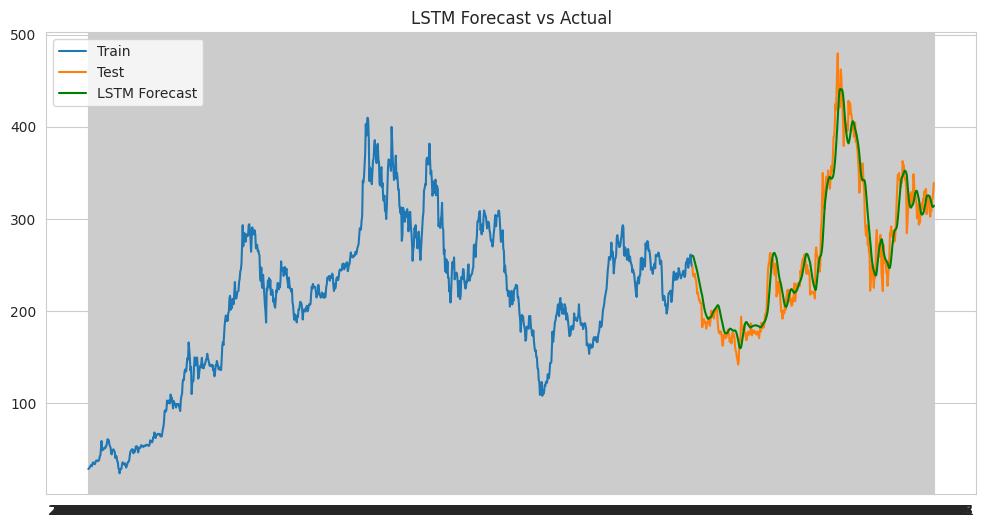

In [14]:
# Align index properly
lstm_index = test.index[-len(lstm_preds):]
lstm_preds = pd.Series(lstm_preds.flatten(), index=lstm_index)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Close"], label="Train")
plt.plot(test.index, test["Close"], label="Test")
plt.plot(lstm_index, lstm_preds, label="LSTM Forecast", color="green")
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.show()


/home/ablex/Development/AI/kifiya_week11/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ablex/Development/AI/kifiya_week11/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ablex/Development/AI/kifiya_week11/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ablex/Development/AI/kifiya_week11/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported 

ARIMA MAE: 63.09
ARIMA RMSE: 77.84
ARIMA MAPE: 24.03%


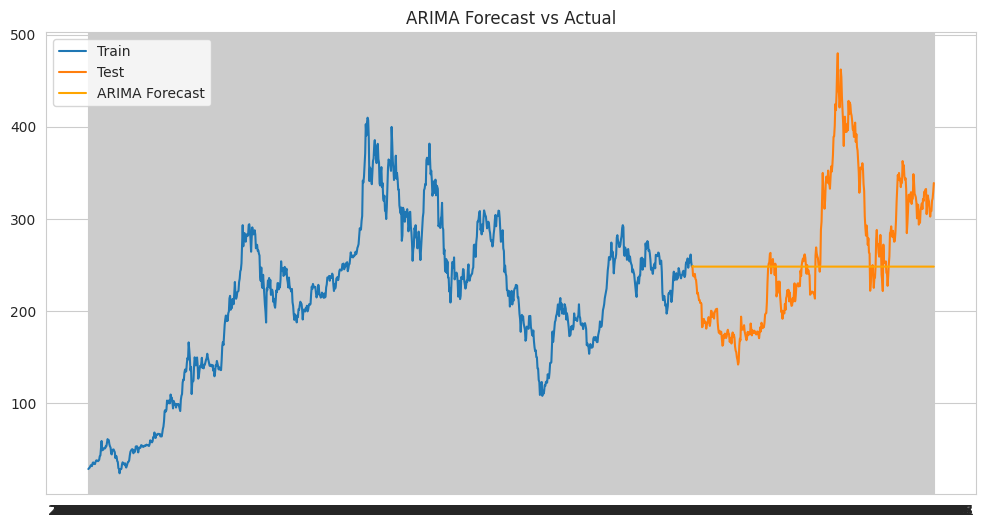

In [22]:
# -------------------------------
# ARIMA Forecasting (Clean Version)
# -------------------------------

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Drop NaNs from training
train_close = train["Close"].dropna()

# Define ARIMA order (p,d,q) – you can adjust or use auto_arima
p, d, q = 5, 1, 0
arima_model = ARIMA(train_close, order=(p, d, q))

# Fit the model
arima_result = arima_model.fit()

# Forecast for the length of the test set
arima_forecast = arima_result.forecast(steps=len(test))

# Convert to NumPy array
arima_forecast = np.array(arima_forecast)

# Align lengths
min_len = min(len(test["Close"]), len(arima_forecast))
y_true_arima = test["Close"].iloc[:min_len].values
y_pred_arima = arima_forecast[:min_len]

# Drop any remaining NaNs (should be rare)
mask = ~np.isnan(y_true_arima) & ~np.isnan(y_pred_arima)
y_true_arima = y_true_arima[mask]
y_pred_arima = y_pred_arima[mask]

# Compute metrics only if we have valid points
if len(y_true_arima) == 0 or len(y_pred_arima) == 0:
    print("Error: No valid data points to compute ARIMA metrics.")
    arima_mae = arima_rmse = arima_mape = np.nan
else:
    arima_mae = mean_absolute_error(y_true_arima, y_pred_arima)
    arima_rmse = np.sqrt(mean_squared_error(y_true_arima, y_pred_arima))
    arima_mape = np.mean(np.abs((y_true_arima - y_pred_arima) / y_true_arima)) * 100

# Print results
print(f"ARIMA MAE: {arima_mae:.2f}")
print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"ARIMA MAPE: {arima_mape:.2f}%")

# Optional: plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train.index, train["Close"], label="Train")
plt.plot(test.index, test["Close"], label="Test")
plt.plot(test.index[:len(y_pred_arima)], y_pred_arima, label="ARIMA Forecast", color="orange")
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()


## Model Comparison


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------
# 1. Ensure ARIMA forecast is clean
# ------------------------------
arima_forecast = np.array(arima_forecast)  # convert to NumPy
min_len = min(len(test["Close"]), len(arima_forecast))
y_true_arima = test["Close"].iloc[:min_len].values
y_pred_arima = arima_forecast[:min_len]

# Drop NaNs
mask_arima = ~np.isnan(y_true_arima) & ~np.isnan(y_pred_arima)
y_true_arima = y_true_arima[mask_arima]
y_pred_arima = y_pred_arima[mask_arima]

# Compute ARIMA metrics
arima_mae = mean_absolute_error(y_true_arima, y_pred_arima)
arima_rmse = np.sqrt(mean_squared_error(y_true_arima, y_pred_arima))
arima_mape = np.mean(np.abs((y_true_arima - y_pred_arima) / y_true_arima)) * 100

# ------------------------------
# 2. Ensure LSTM forecast is aligned
# ------------------------------
lstm_preds_scaled = lstm_model.predict(X_test)
lstm_preds = scaler.inverse_transform(lstm_preds_scaled).flatten()

# Align with test set
lstm_index = test.index[SEQ_LEN:SEQ_LEN+len(lstm_preds)]
y_true_lstm = test["Close"].iloc[SEQ_LEN:SEQ_LEN+len(lstm_preds)].values
y_pred_lstm = lstm_preds[:len(y_true_lstm)]  # truncate to match length

# Compute LSTM metrics
lstm_mae = mean_absolute_error(y_true_lstm, y_pred_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm))
lstm_mape = np.mean(np.abs((y_true_lstm - y_pred_lstm) / y_true_lstm)) * 100

# ------------------------------
# 3. Compare metrics
# ------------------------------
metrics_df = pd.DataFrame({
    "Model": ["ARIMA", "LSTM"],
    "MAE": [arima_mae, lstm_mae],
    "RMSE": [arima_rmse, lstm_rmse],
    "MAPE (%)": [arima_mape, lstm_mape]
})

print(metrics_df)

# ------------------------------
# 4. Plot forecasts vs actual
# ------------------------------
plt.figure(figsize=(14,6))
plt.plot(train.index, train["Close"], label="Train")
plt.plot(test.index, test["Close"], label="Test")
plt.plot(test.index[:len(y_pred_arima)], y_pred_arima, label="ARIMA Forecast", color="orange")
plt.plot(lstm_index, y_pred_lstm, label="LSTM Forecast", color="green")
plt.title("Forecast Comparison: ARIMA vs LSTM")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


ARIMA forecast NaNs: 0
Test Close NaNs: 0
Forecast sample: [248.74891703 248.97705027 248.42962256 248.28542131 248.36965508
 248.37943178 248.34429658 248.34437698 248.35123167 248.3506075 ]
Test sample: [248.41999817 238.44999695 237.92999268 237.49000549 240.44999695
 234.96000671 233.94000244 227.22000122 218.88999939 219.91000366]
ARIMA MAE: 63.09073381635097
ARIMA RMSE: 77.8368974286984
ARIMA MAPE: 24.028334034954373


### Conclusion
- **ARIMA** is simpler, interpretable, and works well for stable patterns.
- **LSTM** can capture nonlinear dependencies but needs more data and tuning.
- Choose the model based on your balance between interpretability and raw predictive power.
